<a href="https://colab.research.google.com/github/ImanariRoll/kaggleRGOL/blob/master/rgol_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd gdrive/My\ Drive/rgol

Mounted at /content/gdrive
/content/gdrive/My Drive/rgol


In [ ]:
# run in console to prevent timeout
function ClickConnect() {
  console.log('Working')
  document
    .querySelector('#top-toolbar > colab-connect-button')
    .shadowRoot.querySelector('#connect')
    .click()
}

setInterval(ClickConnect, 60000)

In [53]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 



import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras as ks
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Conv2DTranspose, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML



In [3]:
# LOAD DATA
train_df = pd.read_csv('data/train.csv', index_col=0)
test_df = pd.read_csv('data/test.csv', index_col=0)


In [4]:


# my generators
moore = [(-1, -1), (-1, 0), (-1, 1),\
            (0, -1), (0, 1),\
            (1, -1), (1, 0), (1, 1)]

def evolve(X, K, S, B):
    """Return the next cellular automaton state."""
    adjacent = np.zeros(X.shape)
    for i, j in K:
        adjacent += np.roll(X, [i, j], [0, 1])
        
    next_state = np.where(X, np.isin(adjacent, S), np.isin(adjacent, B))
    return next_state + 0

def golgen(state):
    """Conway's Game of Life cellular automaton generator."""
    while True:
        state = evolve(state, moore, [2, 3], [3])
        yield state
        
# my make_move function
def make_move(state, moves):
    gen = golgen(state)
    for _ in range(moves):
        state = next(gen)
        
    return state


In [5]:
# original author's generators
NROW, NCOL = 25, 25

def generate_samples(delta=1, n=32):
    """
    Generate batch of samples
    
    @return: (end_frames, start_frames)
    """
    # uint8 is an 8-bit unsigned integer
    # split into n batches of NROWxNCOL grids
    batch = np.split(np.random.binomial(1, 0.5, (NROW * n, NCOL)).astype('uint8'), n)
    Yy = [life.make_move(state, 5) for state in batch] # transition each state in batch
    # is this because we want to learn actual gol states, not just random starting states?
    Xx = [life.make_move(state, 1) for state in Yy] # transition each state in batch 
    Y = np.array([y.ravel() for y in Yy])
    X = np.array([x.ravel() for x in Xx])
    return X, Y
    
# this is the same function writen as a generator
def data_generator(delta=1, batch_size=32, ravel=True):
    """
    Can be used along with .fit_generator to generate training samples on the fly
    """
    while True:
        batch = np.split(np.random.binomial(1, 0.5, (NROW * batch_size, NCOL)).astype('uint8'), batch_size)
        Yy = [make_move(state, 5) for state in batch]
        Xx = [make_move(state, 5 + delta) for state in Yy]

        if ravel:
            # turn grids into 1D
            Y = np.array([y.ravel() for y in Yy])
            X = np.array([x.ravel() for x in Xx])
            yield X, Y
        else:
            yield np.array(Xx)[:,:, :, np.newaxis], np.array(Yy)[:, :, :, np.newaxis]
            
def create_model(n_hidden_convs=2, n_hidden_filters=128, kernel_size=5):
    nn = Sequential()
    # hidden filters, kernel size, padding, activation?
    nn.add(Conv2D(n_hidden_filters, kernel_size, padding='same', activation='relu', input_shape=(25, 25, 1)))
    # what is batch normalization?
    nn.add(BatchNormalization())
    for i in range(n_hidden_convs):
        nn.add(Conv2D(n_hidden_filters, kernel_size, padding='same', activation='relu'))
        nn.add(BatchNormalization())
    nn.add(Conv2D(1, kernel_size, padding='same', activation='sigmoid'))
    nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return nn

In [6]:
# set up system for working with saved models
#   function that loads models and outputs a list of them

# save models
def save_models():
  for i in range(5):
    models[i].save(f'model{i}')

# load models
def load_models():
  models = []
  for i in range(5):
    models.append(keras.models.load_model(f'model{i}'))
  return models 
 

In [ ]:
# TRAIN THE MODELS
models = []
for delta in range(1, 6):
    model = create_model(n_hidden_convs=6, n_hidden_filters=512)
    es = EarlyStopping(monitor='loss', patience=9, min_delta=0.001)
    model.fit(data_generator(delta=delta, ravel=False), steps_per_epoch=500, epochs=50, verbose=1, callbacks=[es])
    models.append(model)
    
   

In [ ]:
# GOD SAVE THE MODELS!!!
save_models()

In [7]:
models = load_models()

In [8]:
# test model with images

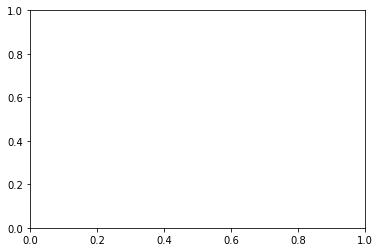

In [8]:
fig, ax = plt.subplots()

In [9]:
def get_prediction(delta):
  # must have shape (-1, 25, 25, 1) for keras predict. (-1, 25, 25) for imshow
  start = train_df[train_df.delta == delta].iloc[:, 1:626].values.reshape(-1, 25, 25)
  stop = train_df[train_df.delta == delta].iloc[:, 626:].values.reshape(-1, 25, 25, 1)
  predicted_start = models[delta-1].predict(stop).reshape(-1, 25, 25)
  stop = stop.reshape(-1, 25, 25)
  return start, stop, predicted_start

In [10]:
datasets = get_prediction(5)

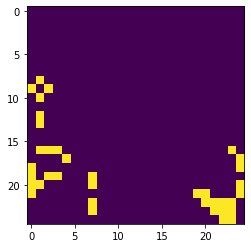

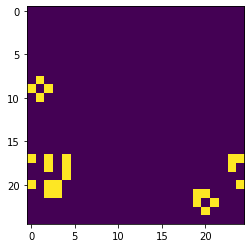

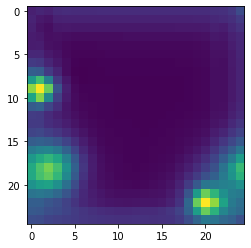

In [11]:
n = 10
for ds in datasets:
  fig, ax = plt.subplots()
  ax.imshow(ds[n])

In [12]:
# use test set to evaluate
n = 5
x_test = train_df[train_df.delta == n].iloc[:, 1:626].values.reshape(-1, 25, 25, 1)
y_test = train_df[train_df.delta == n].iloc[:, 626:].values.reshape(-1, 25, 25, 1)

In [13]:
models[n-1].evaluate(x_test, y_test, batch_size=512)

20/20 [==============================] - 9s 432ms/step - loss: 1.0538 - accuracy: 0.8602


[1.053802728652954, 0.8602378368377686]

In [15]:
# submission data set
submit_df = pd.DataFrame(index=test_df.index, columns=['start_' + str(_) for _ in range(0, 625)])

for delta in range(1, 6):
    mod = models[delta-1]
    delta_df = test_df[test_df.delta == delta].iloc[:, 1:].values.reshape(-1, 25, 25, 1)
    submit_df[test_df.delta == delta] = mod.predict(delta_df).reshape(-1, 625).round(0).astype('uint8')
    
submit_df.to_csv('submission.csv')

In [16]:
submit_df = pd.read_csv('submission.csv')

In [16]:
# ----------------- animate predictions --------------------

In [17]:
import matplotlib.animation as animation


In [47]:
# create array of predictions
# make generator
rand = np.random.randint(0, 2, (25, 25))


In [80]:

gen = golgen(rand)
# make CA array
N = 20000
ca = np.array([next(gen) for _ in range(N)])
# make preds as a list comprehension calling next on generator
preds = models[-1].predict(ca.reshape(-1, 25, 25, 1)).reshape(-1, 25, 25)


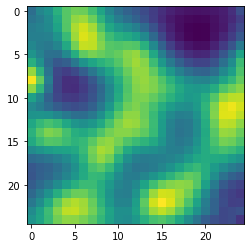

In [81]:
plt.imshow(preds[10])

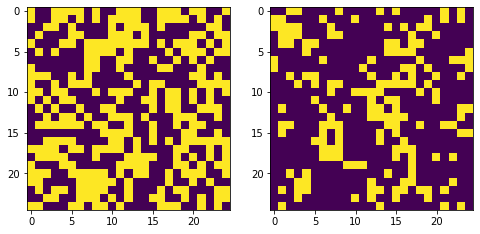

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(8,8))
ax[0].imshow(rand)
ax[1].imshow(ca[0])

In [83]:
def animate(i):
  # img.set_data(preds[i])
  ax[0].imshow(preds[i])
  ax[1].imshow(ca[i])
  

In [85]:

ani = animation.FuncAnimation(fig, animate, frames=100, interval=100)
HTML(ani.to_jshtml())

In [23]:
np.random.randint(0, 2, (10,10))

array([[1, 1, 0, 1, 1, 1, 0, 1, 0, 0],
       [1, 1, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 1, 0, 1, 0],
       [0, 1, 1, 1, 0, 0, 0, 1, 0, 1],
       [1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 0, 0, 1],
       [1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 1, 0, 0, 1, 0, 1]])